In [232]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("default")

In [233]:
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    average_precision_score,
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

Начнем с получение датасета для бинарной классификации. Воспользуемся самым простым вариантом - сгенерируем его:


In [234]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)

Разделим выборку на обучающую и тестовую. В данном случае нам не очень важны будут показатели эффективности моделей, но важно, чтобы и тестовая и обучающая выборки имели достаточное количество точек. Поэтому поделим датасет пополам, хотя на практике такая пропорция не используется:


In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

Создадим и обучим на обучающей выборке простую модель логистической регрессии:


In [236]:
model = LogisticRegression().fit(X_train, y_train)

Логистическая регрессия, наряду со многими другими моделями классификации может работать как точечный предиктор (то есть выдавать для входного объекта наиболее вероятный класс), а может - как вероятностный (то есть для данного объекта выдавать оценки вероятности принадлежности к каждому классу, который присутствует в обучающей выборке). Сейчас мы поработаем как раз с этими вероятностями. Получить их очень легко, воспользуемся специальным методом:


In [237]:
y_pred_proba = model.predict_proba(X_test)

Мы получили матрицу вероятностей:


In [238]:
y_pred_proba[:10]

array([[0.00402958, 0.99597042],
       [0.00200644, 0.99799356],
       [0.99469656, 0.00530344],
       [0.84790996, 0.15209004],
       [0.00166614, 0.99833386],
       [0.49924007, 0.50075993],
       [0.98020876, 0.01979124],
       [0.97650739, 0.02349261],
       [0.01798667, 0.98201333],
       [0.29313254, 0.70686746]])

В этой матрице количество строк совпадает с количеством объектов, которые мы передали методу (в данном случае мы передали всю тестовую выборку). Для каждого объекта в матрице указано два значения - вероятности его отнесения, по мнению модели, соответственно, к отрицательному и положительному классу. Так как задача у нас бинарная, можно заметить, что эти два числа всегда дают в сумме единицу. В общем случае, для множественной классификации, это не обязательно выполняется. Но в даннос случае нам дальше вообще понадобится только второй столбец этой матрицы.

Для построения кривой ROC используем встроенную в sklearn функцию roc_curve, которая находится в пакете metrics:


In [239]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

Данная функция возвражает три массива: значения метрики FPR (false positive rate), TPR (true positive rate) и значение порога. Фактически, данная функция берет определенное количество значений порога (в промежутке от 0 до 1), применяет данный порог для точной классификации, исходя из переданной ей матрицы вероятностей, и вычисляет при данном значении порога две упомянутые метрики.

Значения порога нас пока не очень интересуют, а первые два массива мы используем для построения графика - того самомго ROC:


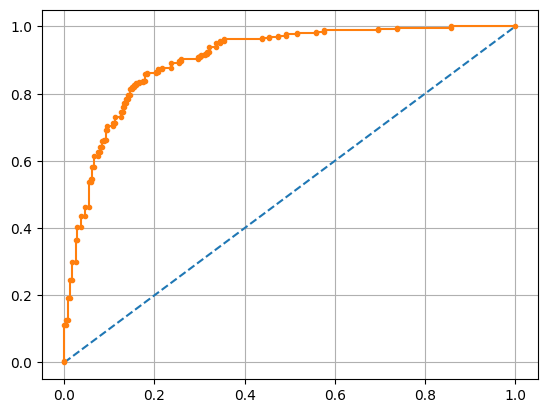

In [240]:
plt.grid("grey")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=".")
plt.show()

Из графика мы видим, что кривая находится выше прямой, что свидетельствует о том, что классификатор работает лучше, чем случайное предсказание. Но можно заметить, что при разных значениях порога (зеленые точки на графике) модель имеет значительно различающиеся характеристики. И только одна точка на этом графике характеризует поведение модели при "дефолтном" значении порога - то, что мы обычно не задумываясь получаем методом predict.

Но анализ графика может нам дать только примерное представление о том, насколько хороша модель. Особенно сейчас, когда нам не с чем ее сравнить. Боле четкую оценку даст метрика ROC-AUC, измеряющая площадь под графиком данной кривой. Эту метрику также легко получить:


In [241]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.9027724358974359

В данном случае, мы имеем значение примерно в 90,3%, что можно интерпретировать как общее качество модели вне зависимости от выбранного порога.

Давайте по аналогии построим график PR-кривой. Из лекции мы знаем, что он строится по аналогичному признаку, но в других координатах. Конечно, библиотека sklearn и здесь позволяет пользоваться готовыми функциями:


In [242]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])

Обратите внимание, что в этих координатах (precision и recall) эффективность тривиального классификатора уже не так примитивна и ависит от соотношения классов в обучающей выборке. Мы уже говорили об этом на лекции. Вот как просто можно его изобразить:


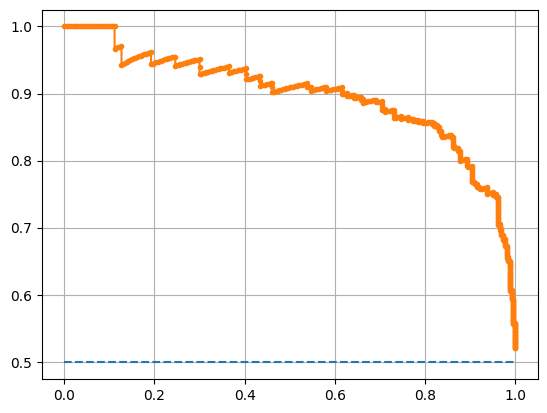

In [243]:
plt.grid("grey")
no_skill = len(y[y == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
# А теперь можно вывести на график и саму кривую PR:

plt.plot(recall, precision, marker=".")
plt.show()


Точно также, как и с ROC можно вычислить соответствующую численную метрику - площадь под графиком PR-кривой - PR-AUC:

In [244]:
auc(recall, precision)

0.897662372903334

Эта метрика численно чуть ниже - порядка 89,8%. Еще это число называют средней точностью модели - average precision.

Полезно посмотреть, как полученные данные соотносятся с уже знакомыми нам характеристиками классификации. Давайте построим отчет о классификации по данной модели:

In [245]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.83      0.82      0.83       240
           1       0.84      0.85      0.84       260

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



Важно понимать, что данный отчет характеризует поведение модели только в одной точке - при значении порога, равном по умолчанию 0,5. Кривые же показывают, как модель будет работать при все возможных значениях порога.

Давайте для сравнения попробуем обучить на этих же данных другую модель. Например, метод ближайших сосдей. Вы можете выбрать любую другую модель (но обратите внимание, что не все модели имеют метод redict_proba, а нам он обязательно понадоится. Почему так, читайте в документации к моделям):

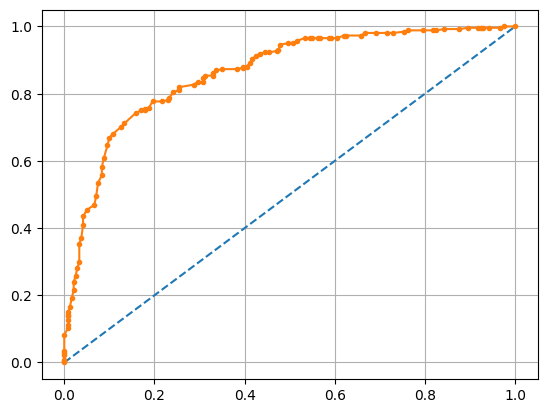

In [246]:
plt.grid("grey")
model2 = KNeighborsClassifier(n_neighbors=250).fit(X_train, y_train)
y_pred2_proba = model2.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred2_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=".")
plt.show()


График будет выглядеть чуть по-другому, но в целом похоже на ROC первой модели. Поэтому для точного сравнения более полезны численные метрики:

In [247]:
roc_auc_score(y_test, y_pred2_proba[:, 1])

0.8630608974358974

Тут явно видно, что ROC-AUC второй модели значимо хуже - 86,3%.


Дизбаланс классов
Наиболее явно различия между этими двумя классификационными кривыми - ROC и PR - демонстрирует пример с большим дизбалансом классов. Давайте сгенерируем датасет, в котором объектов разных классов не примерно равное количество, как в предыдущем примере, а объектов отрицательного класса, скажем, 99%. Для этого очень удобно воспользоваться атрибутом weights функции make_classification:

In [248]:
X, y = make_classification(
    n_samples=1000, n_classes=2, weights=[0.99, 0.01], random_state=1
)

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4)

print("Датасет: Class0=%d, Class1=%d" % (len(y[y == 0]), len(y[y == 1])))
print(
    "Обучающая: Class0=%d, Class1=%d"
    % (len(y_train[y_train == 0]), len(y_train[y_train == 1]))
)
print(
    "Тестовая: Class0=%d, Class1=%d"
    % (len(y_test[y_test == 0]), len(y_test[y_test == 1]))
)


Датасет: Class0=985, Class1=15
Обучающая: Class0=490, Class1=10
Тестовая: Class0=495, Class1=5


Видно, что в одной половине выборки положительных объектов в два раза больше, чем в другой. Прислучайном разделении, если есть сильно миноритарные классы, может случиться и не такое. Например, мы можем случайно получить выборку, в которой какие-то классы не представлены вообще. Для предотвращения таких случаев нужно воспользоваться стратификацией:

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

Это агрумент следит за тем, чтобы в обоих частях выборки распределение переданного атрибута было примерно такое же, как и целом датасете. Вот какая картина получается сейчас:

In [251]:
print("Датасет: Class0=%d, Class1=%d" % (len(y[y == 0]), len(y[y == 1])))
print(
    "Обучающая: Class0=%d, Class1=%d"
    % (len(y_train[y_train == 0]), len(y_train[y_train == 1]))
)
print(
    "Тестовая: Class0=%d, Class1=%d"
    % (len(y_test[y_test == 0]), len(y_test[y_test == 1]))
)


Датасет: Class0=985, Class1=15
Обучающая: Class0=493, Class1=7
Тестовая: Class0=492, Class1=8


Распределение уже гораздо более равномерное. Для стратификации можно задавать любой массив, не обязательно значение целевой переменной, и разделение произойдет так, чтобы созранить распределение, заданное в этом массиве. Но целевую переменную здесь используют чаще всего.

Точно также, как и в предыдущем примере, обучим модель и сразу вычислим матрицу вероятностей:

In [252]:
model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)


Сразу познакомимся с дефолтным поведением модели, построив отчет о классификации:

In [253]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       492
           1       0.00      0.00      0.00         8

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.98      0.98       500



c:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Здесь мы видим классическую картину обучения на неравномерной выборке. Мажоритарный класс (в данном случае - отрицательный, он у нас в большинстве) распознается очень хорошо, а миноритарный - очень плохо. В нашем случае, вообще по положительному классу все метрики нулевые. Но обратите внимание, что общая точность (accuracy) модели весьма приемлема - 98%. Дизбаланс классов "скрывает" в точности недостатки работы модели.

Построим ROC данной модели:

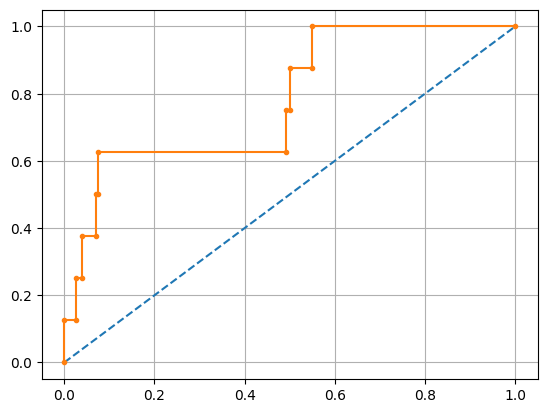

In [254]:
plt.grid("grey")
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=".")
plt.show()


Мы видим. что вривая показывает не идеальное, но вполне примелемое поведение модели. Средняя точность будет, несомненно, ниже, чем в первом примере работы, но ничего катастрофического мы здесь не наблюдаем. Но давайте построим кривую PR:

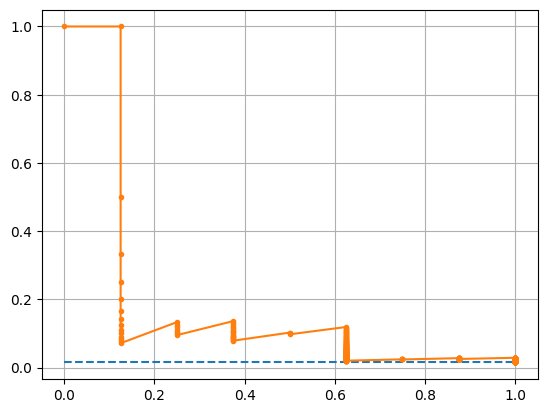

In [255]:
plt.grid("grey")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
no_skill = len(y[y == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
plt.plot(recall, precision, marker=".")
plt.show()


И вот на этом графике уже открывается истинное поведение модели: она не очень-то отличается от тривиальной, просто чаще предсказывает самый распространенный класс. Так как метрики Precision и Recall специально были созданы для случая несбалансированных классов, именно PR-кривая дает более реалистические оценки эффективности работы моделей классификации на таких данных, где наблюдается большой дисбаланс классов.

Выбор значения порога по кривым
Кривые классификации, несомненно, удобный и визуальный способ представления эффективности работы моделей машинного обучения. Но главная их ценность состоит в том, что данные, которые необходимы для их построения могут использоваться для оптимизации порога классификации. Мы уже поняли, что разные значения порога могут приводить к разному поведению моделей и, как следствие, к имзенению метрик. Значит, можно выбрать такой порог, который дает более точную классификацию?

Да, но для этого нам понадобится некоторый критерий - численное значение, которые мы хотим оптимизировать. В лекции мы уже говорили, что простые метрики - precision, recall, accuracy - не очень подходят на роль критерия оптимизации. Но мы можем использовать, например, метрику F1 (и любые метрики из F-семейства). Для этого еще раз сгенерируем датасет, сделаем чуть больше объем данных:

In [256]:
X, y = make_classification(
    n_samples=10000, n_classes=2, weights=[0.99, 0.01], random_state=1
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)


Изобразим PR-кривую:

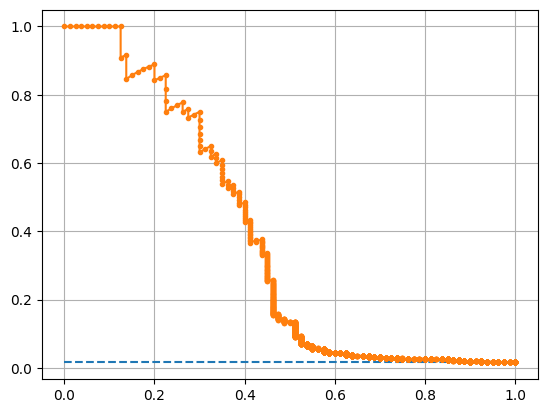

In [257]:
plt.grid("grey")
p, r, pr_thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
no_skill = len(y[y == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
plt.plot(r, p, marker=".")
plt.show()


По точкам на ней мы видим, что при разных значениях порога иногда метрика precision будет больше, иногда - recall. Именно поэтому мы будем оптимизировать по метрике F1. Для этого импортируем из бибилиотеки numpy функцию argmax:

Вычислим вектор метрик F1 при всех использованных значениях порога и найдем самое большое значение среди них (вернее, его индекс):

In [258]:
f1 = (2 * p * r) / (p + r)
ix = np.argmax(f1)
pr_thresholds[ix]


0.1707995281478147

In [259]:
print("Порог=%f, F-Score=%.3f" % (pr_thresholds[ix], f1[ix]))

Порог=0.170800, F-Score=0.444


Теперь мы можем изобразить эту точку на графике самой кривой:

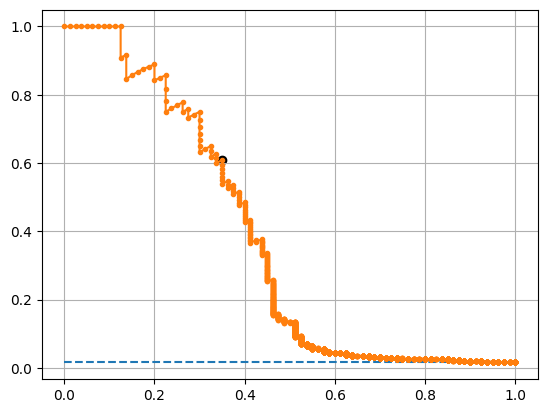

In [260]:
plt.grid("grey")
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
plt.plot(r, p, marker=".")
plt.scatter(r[ix], p[ix], marker="o", color="black")
plt.show()


Обратите внимание, что мы использовали метрику F1 - это среднее геометрическое между Precision и Recall. При этом эти две метрики имеют равный вклад в среднее. Бывают ситуации, когда нам более приоритетна одна из этих двух метрик. Тогда следует использоваться параметрическую метрику из F-семейства. Мы можем придать в среднем разный вес, то есть больше предпочесть recall или, наоборот, precision.

Давайте используем данное значение порога для проведение непосредственной классификации. Раньше мы так не делали, так как всегда использовали метод predict, который всегда использует порог по умолчанию - 0,5. Но точечная классификация - это не что иное, как выбор положительного класса, если модель оценивает вероятность принадлежности к нему выше порога:

In [261]:

y_pred = (y_pred_proba[:, 1] > pr_thresholds[ix]).astype('int')


Полученный вектор значений можно использовать при построении точета о классфикации:

In [262]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4920
           1       0.60      0.34      0.43        80

    accuracy                           0.99      5000
   macro avg       0.79      0.67      0.71      5000
weighted avg       0.98      0.99      0.98      5000



А вот для сравнения, отчет о классификации для той же модели, но при использованиии порога по умолчанию:

In [263]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4920
           1       0.91      0.12      0.22        80

    accuracy                           0.99      5000
   macro avg       0.95      0.56      0.61      5000
weighted avg       0.98      0.99      0.98      5000



Видно что модль с нашим порогом получила большую точноссть

# ДЗ

Повторите анализ из лабораторной работы, но с двумерными датасетами. Изобразите графически, как изменение порога влияет на расположение границы принятия решений.

In [264]:
X, y = make_classification(
    n_samples=1000,
    n_classes=2,
    random_state=1,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    class_sep=1.5,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)


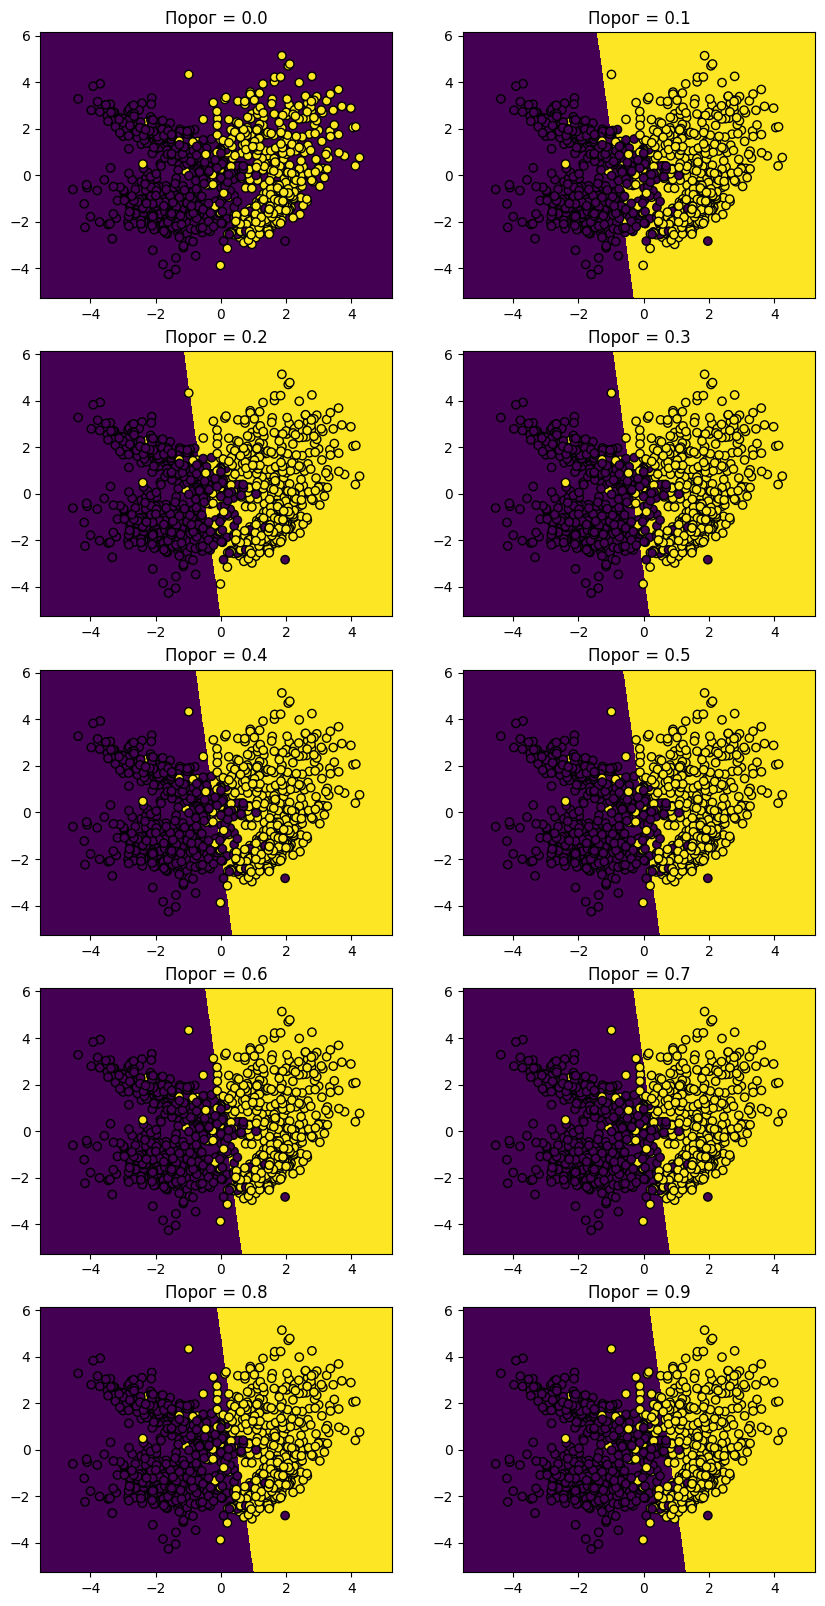

In [265]:
fit, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 20))
X0 = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, X.shape[0])
X1 = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, X.shape[0])
X0_grid, X1_grid = np.meshgrid(X0, X1)

y_predict = (
    model.predict_proba(np.c_[X0_grid.ravel(), X1_grid.ravel()])[:, 1]
).reshape(X0_grid.shape)
for axis, threshold in zip(np.ravel(ax), np.arange(0, 1, 0.1)):
    axis.pcolormesh(X0_grid, X1_grid, y_predict > threshold)
    axis.set_title("Порог = " + str(round(threshold, 2)))
    axis.scatter(X[:, 0], X[:, 1], c=y, edgecolors="black", linewidth=1)


Повторите анализ на реальном датасете для бинарной классификации. Проинтерпретируйте результат, сделайте вывод.

In [266]:
diabetes = pd.read_csv("diabetes.csv")
diabetes.head()


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [267]:
X = diabetes.drop('Diabetic', axis=1)
y = diabetes.Diabetic

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [269]:
model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)

c:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


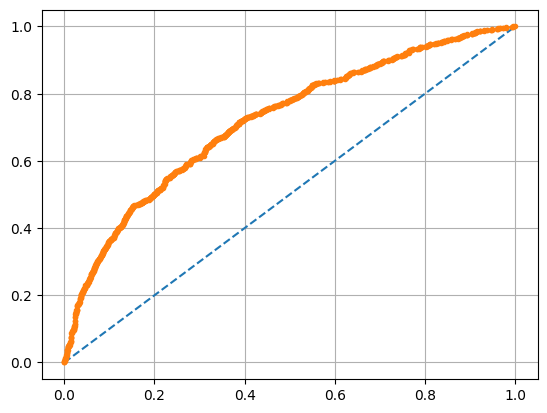

0.7190845

In [270]:
# ROC кривая
plt.grid("grey")
fpr, tpr, tr = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=".")
plt.show()
roc_auc_score(y_test, y_pred_proba[:, 1])


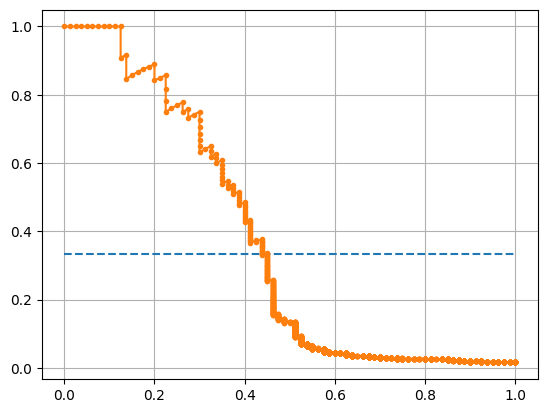

0.564230067187267

In [293]:
plt.grid("grey")
precision, recall, tr = precision_recall_curve(y_test, y_pred_proba[:, 1])
no_skill = len(y[y == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
plt.plot(r, p, marker=".")
plt.show()
auc(recall, precision)


В среднем модель получилась не очень точной

---
В задании по оптимизации порога используйте ROC и среднее геометрическое между TPR и FPR как критерий оптимизации.

0.3468795512443092

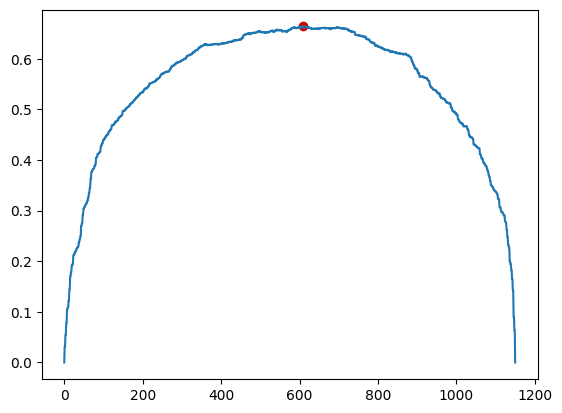

In [272]:
gmean = (tpr * (1 - fpr)) ** 0.5
plt.plot(gmean)
maxim = (gmean).argmax()
plt.scatter(maxim, gmean[maxim], c="r")
threshold = tr[maxim]
threshold


In [273]:
# Стандартный порог
print(classification_report(y_test, y_pred_proba[:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81      2000
           1       0.63      0.39      0.48      1000

    accuracy                           0.72      3000
   macro avg       0.69      0.64      0.64      3000
weighted avg       0.71      0.72      0.70      3000



In [287]:
# Оптимальный порог
print(classification_report(y_test, y_pred_proba[:, 1] > threshold))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73      2000
           1       0.50      0.66      0.57      1000

    accuracy                           0.67      3000
   macro avg       0.65      0.66      0.65      3000
weighted avg       0.70      0.67      0.67      3000



---
При оптимизации порога по PR-кривой используйте другую F-метрику - сначала с преимуществом precision, а затем - с превалированием recall. Изобразите получившиеся пороги на графике. Проанализируйте метрики получившихся моделей.

In [294]:
# Преимущество precision
# 5 > 2
f1 = (5 * precision * recall) / (4 * precision + recall)
ix = np.argmax(f1)
print(tr[ix])
print(classification_report(y_test, y_pred_proba[:, 1] > tr[ix]))


0.11459735861165492
              precision    recall  f1-score   support

           0       0.92      0.09      0.16      2000
           1       0.35      0.98      0.52      1000

    accuracy                           0.39      3000
   macro avg       0.63      0.54      0.34      3000
weighted avg       0.73      0.39      0.28      3000



У модели высокая точность, но при этом низкая полнота

In [295]:
# Преимущество recall
# 1.25 < 2
f1 = (1.25 * precision * recall) / (0.25 * precision + recall)
ix = np.argmax(f1)
print(tr[ix])
print(classification_report(y_test, y_pred_proba[:, 1] > tr[ix]))


0.45869723973239623
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      2000
           1       0.60      0.47      0.53      1000

    accuracy                           0.72      3000
   macro avg       0.68      0.66      0.66      3000
weighted avg       0.71      0.72      0.71      3000



Тут же наоборот, хорошая полнота, но низкая точность

---
Постройте классификационные кривые для задачи множественной классификации. Проинтерпретируйте результат.

In [214]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
model3 = KNeighborsClassifier().fit(X_train, y_train)
y_pred_proba = model3.predict_proba(X_test)

1.0
1.0
1.0


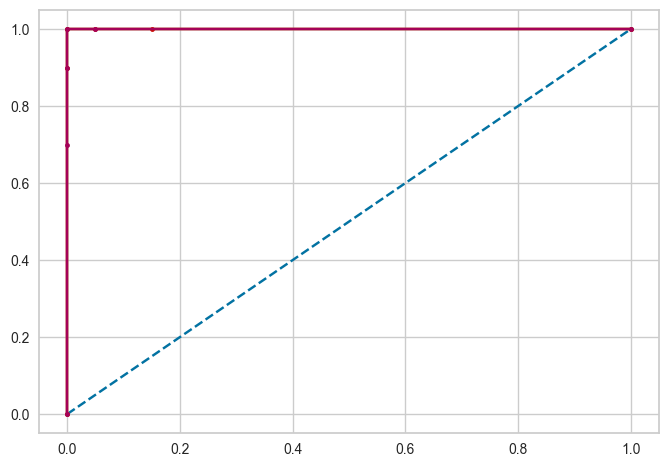

In [223]:
# ROC кривая
plt.grid("grey")

plt.plot([0, 1], [0, 1], linestyle="--")
for clas in [0, 1, 2]:
    fpr, tpr, tr = roc_curve(y_test == clas, y_pred_proba[:, clas])
    plt.plot(fpr, tpr, marker=".")
    print(roc_auc_score(y_test == clas, y_pred_proba[:, clas]))
    


Для каждого класса получилась максимальная точность

In [ ]:
confusion_matrix(y_test, model3.predict(X_test))

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  1,  9]], dtype=int64)

1.0
1.0
1.0


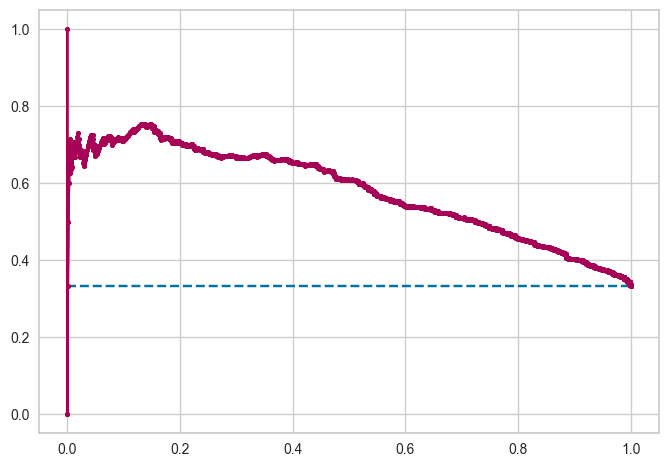

In [231]:
# PR кривая
fig, ax = plt.subplots()
plt.grid("grey")
ax.plot([0, 1], [no_skill, no_skill], linestyle="--")
for clas in [0, 1, 2]:
    precision, recall, pr_thresholds = precision_recall_curve(
        y_test == clas, y_pred_proba[:, clas]
    )
    no_skill = len(y[y == 1]) / len(y)
    ax.plot(r, p, marker=".")
    print(auc(recall, precision))


---
Используйте для построения кривых библиотеку yellowbrick.

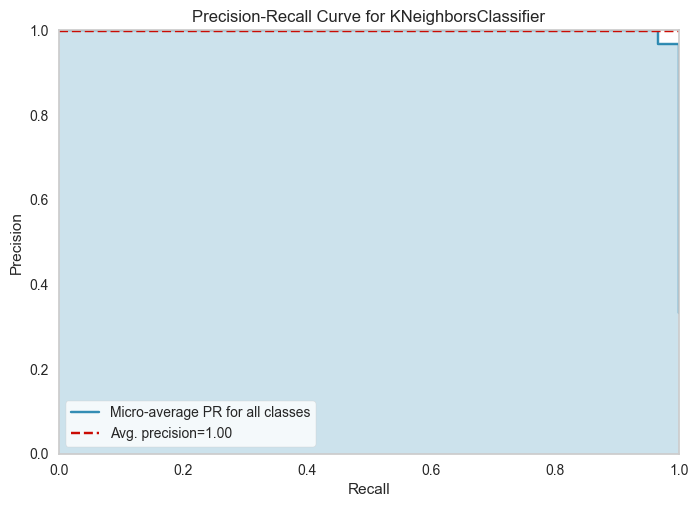

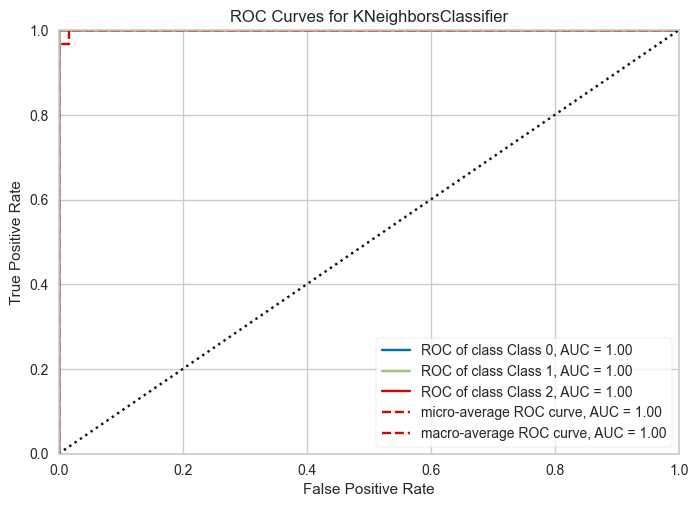

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [215]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

# PR кривая
prc_visualizer = PrecisionRecallCurve(model3, classes=["Class 0", "Class 1", "Class 2"])
prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

# ROC кривая
roc_visualizer = ROCAUC(model3, classes=["Class 0", "Class 1", "Class 2"])
roc_visualizer.fit(X_train, y_train)
roc_visualizer.fit(X_train, y_train)
roc_visualizer.score(X_test, y_test)
roc_visualizer.show()
